In [1]:
#Llamando al archivo del código xicosmo.py donde están hechas las definiciones para obtener xifull.
from xicosmo_z234cmplt import *
from numpy import *
from itertools import product #Usado
from matplotlib import colors
import astropy.io.fits as ft #Repositorio de Python para leer archivos o  imagenes .fits
import scipy.optimize as opt
import emcee
import corner
from IPython.display import display, Math
import pickle

# Calling correlation and covariance data of another code
cor=ft.open('cf_z_0_10-exp.fits.gz') #output
correlation=cor['COR'].data['DA']
covariance=cor['COR'].data['CO']
distortion=cor['COR'].data['DM']

C:\Users\Rafael\anaconda3\lib\site-packages\scipy\integrate\_quadpack_py.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


# Definitions

## $\chi^2$

In [52]:
def conversion(rp, rt):
    point = list(product(rp, rt))
    #point=np.array(list(zip(rp, rt)))
    rvec=np.array(point)
    rplist=list()
    for numb in range(len(point)):
        rplaux=rvec[numb,0]
        rplist.append(rplaux)
    rpl=np.array(rplist)
    rmagl=list()
    for i in rvec:
        raux=np.sqrt(i.dot(i))
        rmagl.append(raux)
    rmag=np.array(rmagl)
    muklist=rpl/rmag
    return rmag, muklist

def ji2(parameters, rjlist, miuklist,  sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp):
    bF, beta, alphapl, alphapp = parameters
    xicoslist = xifull(rjlist, miuklist, bF, beta, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp, alphapl, alphapp)
    xicos=np.array(xicoslist)
    xidistorted=np.dot(distortion, xicos)
    correlation_vec=np.ndarray.flatten(correlation)
    xiA=(correlation_vec - xidistorted)*mask
    xiA.resize((1,2500), refcheck=False)
    xiB=(correlation_vec - xidistorted)*mask 
    covariance_inv=np.linalg.inv(covariance)
    return np.dot(np.dot(xiA,covariance_inv),xiB)

## Minimization of $\chi^2$

In [53]:
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    bF, beta, alphapl, alphapp = p
    # We're using only uniform priors, and only eps has a lower bound
    if bF >= 0:
        return -np.inf
    return 0

def lnlike(p, rjlist, miuklist,  sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp):
    #bF, beta, alphap, alphat = p
    return -0.5*ji2(p, rjlist, miuklist,  sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp)

def lnprob(p, rjlist, miuklist,  sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp):
    lp = lnprior(p)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(p, rjlist, miuklist,  sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp)

## $D_H/r_d$ and $D_A/r_d$ plots

In [3]:
def Hz(z, Om0, OmDE, H0):
    return H0*np.sqrt(Om0*(1 + z)**3 + OmDE)

def ratio_H(z, alphap, Om0, OmDE, H0, c, rd):
    return (alphap*c)/(Hz(z, Om0, OmDE, H0)*rd)

def f_H(z, Om0, OmDE, H0):
    return Hz(z, Om0, OmDE, H0)/(1 + z)

def point_H(z, alphap, Om0, OmDE, H0, c, rd):
    return  c/((1 + z)*ratio_H(z, alphap, Om0, OmDE, H0, c, rd)*rd)

#With uncertinties
def dratio_H(z, Om0, OmDE, H0, alphap, dalphap, c, rd):
    return (c*dalphap)/(rd*Hz(z, Om0, OmDE, H0))

def dpoint_H(z, Om0, OmDE, H0, alphap, dalphap, c, rd, rdp, drdp):
    return (c*(rdp*dratio_H(z, Om0, OmDE, H0, alphap, dalphap, c, rd) + ratio_H(z, alphap, Om0, OmDE, H0, c, rd)*drdp))/((1 + z)*(rdp*ratio_H(z, alphap, Om0, OmDE, H0, c, rd))**2)

def argD_A(z, Om0, OmDE):
    return 1/np.sqrt(Om0*(1 + z)**3 + OmDE)
def D_A(Om0, OmDE, H0, c):
    DAlist=list()
    for i in z_H:
        res, err = quad(argD_A, 0, i, args=(Om0, OmDE))
        DAaux = res/(1 + i) 
        DAlist.append(DAaux)
    DA=np.array(DAlist)
    return (c/(H0*1e+3))*DA 

def ratio_A(z, alphat, Om0, OmDE, H0, c, rd):
    res, err = quad(argD_A, 0, z, args=(Om0, OmDE))
    return ((alphat*c)/(H0*rd))*(res/(1 + z))

def point_A(z, alphat, Om0, OmDE, H0, c, rd, rdp):
    return (ratio_A(z, alphat, Om0, OmDE, H0, c, rd)*rdp)/1e+3

#With uncertinties
def dratio_A(z, alphat, dalphat, Om0, OmDE, H0, c, rd):
    res, err = quad(argD_A, 0, z, args=(Om0, OmDE))
    return (c*dalphat*res)/(H0*rd*(1 + z))

def dpoint_A(z, alphat, dalphat, Om0, OmDE, H0, c, rd, rdp, drdp):
    return (rdp*dratio_A(z, alphat, dalphat, Om0, OmDE, H0, c, rd) + ratio_A(z, alphat, Om0, OmDE, H0, c, rd)*drdp)/1e+3

## Probability of $\chi^2$

In [8]:
def argProb(ji2, nu):
    return np.exp(-((ji2 - nu)**2/(4*nu)))

def Prob(nu, ji20):
    res, err = quad(argProb, ji20, np.inf, args=(nu,))
    return res/np.sqrt(4*np.pi*nu)

# Obtention of $\chi^2$ and the parameters $b_F$, $\beta$, $\alpha_p$, $\alpha_t$

In [10]:
#Determinando rp y rt
r_max=200
bin_size=4 #El tamaño de separación de los "bines" es de 4 Mpc/h
rp=np.arange(0, r_max, bin_size) + (bin_size/2)
rt=np.arange(0, r_max, bin_size) + (bin_size/2)
r, muk = conversion(rp, rt)

mask=(40<r)*(r<180)
np.sum(mask)

p = bF_true, beta_true, alphap_true, alphat_true

In [12]:
#Obtención de la lista de xilsmooth y xilpeak
start=time.time() #Toma el tiempo de ejecución del código
ji_2 = ji2(p, r, muk, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp)
print(ji_2)
end=time.time()
print("The time of execution of above program is :", end-start)

[2084.14340834]
The time of execution of above program is : 2.630126714706421


In [13]:
#Obtención de la lista de xilsmooth y xilpeak
start=time.time() #Toma el tiempo de ejecución del código
xicosmodel=xifull(r, muk, bF_true, beta_true, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp, alphap_true, alphat_true)
xicosmodel=np.array(xicosmodel)
end=time.time()
print("The time of execution of above program is :", end-start)

The time of execution of above program is : 1.556105613708496


In [51]:
#rp_cut=rp[3:45]
#rt_cut=rp[3:45]
#print(rp_cut)
#print(rt_cut)

In [47]:
xidistorted=np.dot(distortion, xicosmodel)
xidistorted.resize((50,50), refcheck=False)
ximin, ximax=-2.5, 1.0
normxi=colors.Normalize(vmin=ximin, vmax=ximax)
rpp, rpl = np.meshgrid(rt, rp)

In [49]:
#Observational data
correlation.reshape((50,50))

array([[ 1.01226875e-02,  5.00393605e-03,  3.20370156e-03, ...,
        -9.48472257e-06, -4.65169635e-06,  1.13895759e-06],
       [ 1.49340698e-03,  1.87098329e-03,  1.68001638e-03, ...,
        -6.67469699e-06, -1.23781587e-05, -3.21652770e-06],
       [-1.00488290e-04,  3.25654182e-04,  6.01283705e-04, ...,
         3.84974580e-06, -1.76126825e-05, -1.31531944e-05],
       ...,
       [ 1.01344502e-04,  9.27263084e-05,  5.04352311e-05, ...,
         4.10097827e-06,  2.60262624e-06, -4.20812572e-06],
       [ 2.07364570e-04,  7.64632392e-05,  5.49437880e-05, ...,
        -6.19978731e-07,  5.21489807e-06,  3.49135296e-08],
       [ 7.11199334e-05,  1.06143865e-04,  1.36545013e-04, ...,
        -6.31923312e-06, -3.88619520e-06, -4.37217190e-06]])

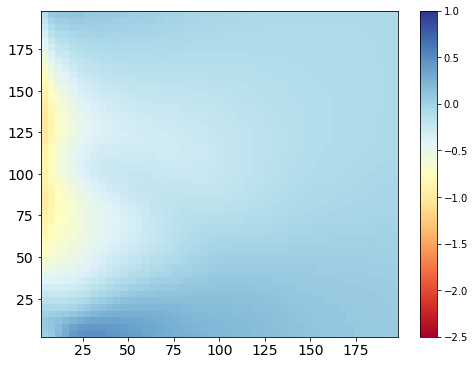

In [50]:
plt.figure(figsize=(8,6))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.pcolormesh(rpp,rpl,(rpp**2 + rpl**2)*xidistorted, norm=normxi, cmap='RdYlBu')
plt.colorbar(norm=normxi)
plt.show()

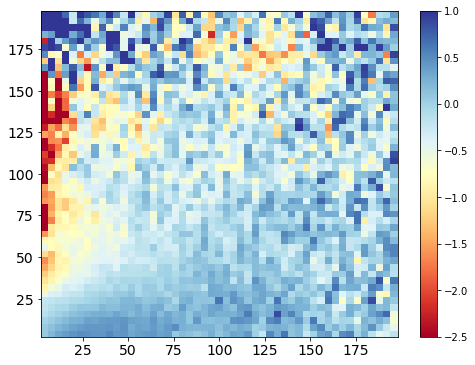

In [34]:
plt.figure(figsize=(8,6))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.pcolormesh(rpp,rpl,(rpp**2 + rpl**2)*correlation.reshape((50,50)), norm=normxi, cmap='RdYlBu')
plt.colorbar(norm=normxi)
plt.show()

In [54]:
#Minimization of \chi^2
start=time.time() #Toma el tiempo de ejecución del código
nll = lambda *args: -lnlike(*args)
result = opt.minimize(nll, [bF_true, beta_true, alphap_true, alphat_true], args=(r, muk, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp))
print(result['x'])
end=time.time()
print("The time of execution of above program is :", end-start)

[-0.18593177  0.94885598  1.05274459  1.01998324]
The time of execution of above program is : 684.8383967876434


In [55]:
result = -0.18593177, 0.94885598, 1.05274459, 1.01998324
bF_min, beta_min, alphap_min, alphat_min = result

In [56]:
#Obtention of \chi^2 with minimized values
#Obtención de la lista de xilsmooth y xilpeak
start=time.time() #Toma el tiempo de ejecución del código
ji_22 = ji2(result, r, muk, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp)
print(ji_22)
end=time.time()
print("The time of execution of above program is :", end-start)

[1655.77851845]
The time of execution of above program is : 2.9755561351776123


In [57]:
#Obtención de la lista de xilsmooth y xilpeak
start=time.time() #Toma el tiempo de ejecución del código
xicosmodel_2=xifull(r, muk, bF_min, beta_min, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp, alphap_min, alphat_min)
xicosmodel=np.array(xicosmodel)
end=time.time()
print("The time of execution of above program is :", end-start)

The time of execution of above program is : 1.15647292137146


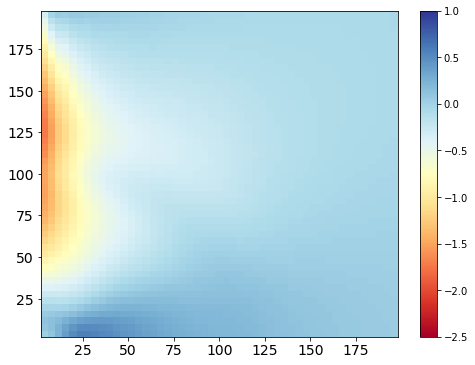

In [58]:
xidistorted_2=np.dot(distortion, xicosmodel_2)
xidistorted_2.resize((50,50), refcheck=False)

plt.figure(figsize=(8,6))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.pcolormesh(rpp,rpl,(rpp**2 + rpl**2)*xidistorted_2, norm=normxi, cmap='RdYlBu')
plt.colorbar(norm=normxi)
plt.show()

In [59]:
Nwalker, Ndim = 32, 4
p0 = [result + 1.e-4*random.randn(Ndim) for i in range(Nwalker)]

In [60]:
start=time.time() #Toma el tiempo de ejecución del código
sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(r, muk, sigp, sigt, Apeak, kNL, kP, kv0, kV, aNL, aP, av, aV, Rp))
sampler.run_mcmc(p0, 500, progress=True)
end=time.time()
print("The time of execution of above program is :", end-start)

100%|█████████████████████████████████████| 500/500 [13:06:47<00:00, 94.41s/it]

The time of execution of above program is : 47293.14226651192


In [61]:
with open('sampler.pickle', 'wb') as f:
    pickle.dump(sampler, f)

In [62]:
with open('sampler.pickle', 'rb') as f:
    sampler = pickle.load(f)

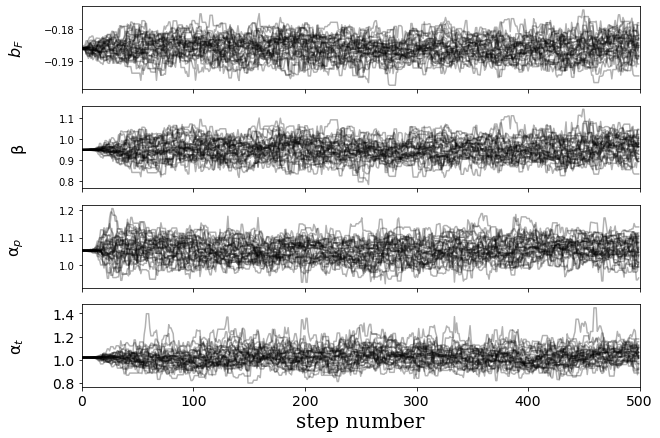

In [73]:
#Para 32 Nwalker para un camino de 500.
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
plt.xticks(fontsize=14)
font1={'size':16}
font2={'family':'serif','size':20}
samples = sampler.get_chain()
labels = ["$b_F$", "\u03B2", "\u03B1$_p$", "\u03B1$_t$"]
for l in range(Ndim):
    ax = axes[l]
    ax.plot(samples[:, :, l], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[l], fontdict=font1)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.yticks(fontsize=14)

axes[-1].set_xlabel("step number", fontdict=font2);

In [74]:
#..we can look at an estimate of the integrated autocorrelation time
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [22.51505409 23.70064967 23.34183479 22.16911571]

In [75]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(960, 4)


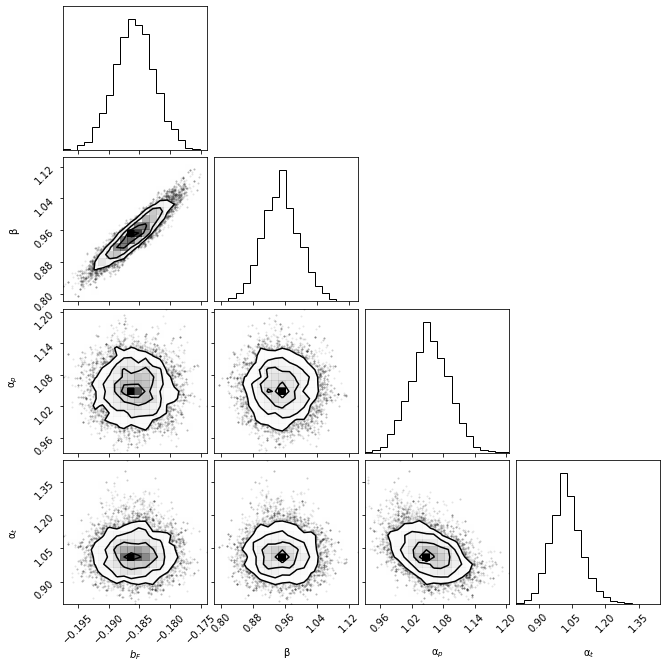

In [76]:
#Para 32 Nwalker para un camino de 500, tercera ronda.
fig2 = corner.corner(sampler.flatchain, labels=labels)

In [77]:
#Incertidumbres obtenidas con percentile, que nos dice la forma de la distribución de los parámetros. 
#Estas incertidumbres serán reportadas en la tesis.
labels2 = ["bF", "\u03B2", "\u03B1_p", "\u03B1_t"]
for i in range(Ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [78]:
#Incertidumbres obtenidas con standard deviation, lo cual nos da unas incertidumbres simétricas.
#Estas incertidumbres serán usadas en las gráficas.
labels2 = ["bF", "\u03B2", "\u03B1_p", "\u03B1_t"]
for i in range(Ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    standard=np.std(flat_samples[:, i])
    txt = "\mathrm{{{2}}} = {0:.3f}{{\u00B1}}{1:.3f}"
    txt = txt.format(mcmc[1], standard, labels2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Obtention of $D_H/r_d$, $D_A/r_d$ and plots

In [79]:
#Parameters
z_H=np.linspace(0,3,1000)

#Obtained values of Planck collaboration 2018
Om0=0.3153
dOm0=0.0073
OmDE=0.6847
dOmDE=0.0073
H0=67.36
dH0=0.54
Ombh2=0.02237
dOmbh2=0.00015
h=0.7
c=3e+5 #km/s
z_drag_model=1060
rd_fid=147.09 #Planck value without uncertintie
rd_planck=147.09
drd_planck=0.26
z_Lya=2.34

dalphap_min=0.037
dalphat_min=0.073

In [80]:
ratioH = ratio_H(z_Lya, alphap_min, Om0, OmDE, H0, c, rd_fid)
dratioH = dratio_H(z_Lya, Om0, OmDE, H0, alphap_min, dalphap_min, c, rd_fid)

txt = "\mathrm{{{0}}} = {1:.2f}{{\u00B1}}{2:.2f}"
txt = txt.format('D_H(z=2.34)/r_d', ratioH, dratioH)
display(Math(txt))

<IPython.core.display.Math object>

In [82]:
ratioA = ratio_A(z_Lya, alphat_min, Om0, OmDE, H0, c, rd_fid)
dratioA = dratio_A(z_Lya, alphat_min, dalphat_min, Om0, OmDE, H0, c, rd_fid)

txt = "\mathrm{{{0}}} = {1:.2f}{{\u00B1}}{2:.2f}"
txt = txt.format('D_A(z=2.34)/r_d', ratioA, dratioA)
display(Math(txt))

<IPython.core.display.Math object>

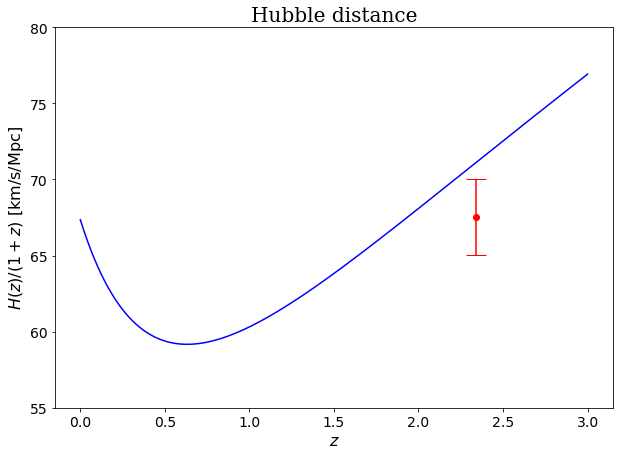

In [81]:
fHvalues = f_H(z_H, Om0, OmDE, H0)
DHLya = point_H(z_Lya, alphap_min, Om0, OmDE, H0, c, rd_fid)
dHerror = dpoint_H(z_Lya, Om0, OmDE, H0, alphap_min, dalphap_min, c, rd_fid, rd_planck, drd_planck)

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
font1={'size':16}
font2={'family':'serif','size':20}
plt.xlabel('$z$', fontdict=font1)
plt.ylabel('$H(z)/(1 + z)$ [km/s/Mpc]', fontdict=font1)
plt.title('Hubble distance', fontdict=font2)
#plt.grid()
plt.plot(z_H, fHvalues, color = 'blue')
plt.errorbar(z_Lya, DHLya, yerr=dHerror, fmt="o", color = 'red', capsize=10)
plt.ylim(55, 80)
plt.show()

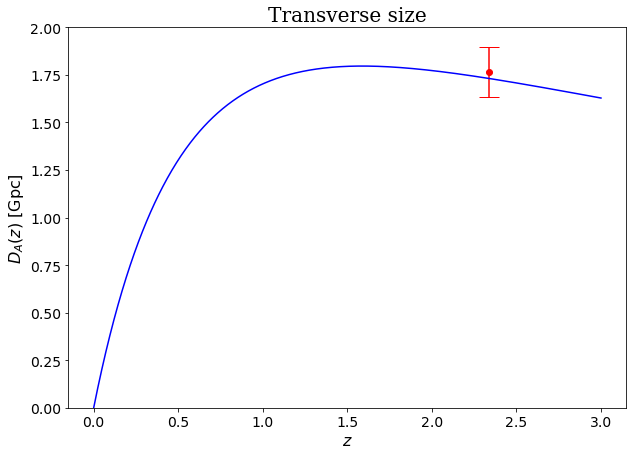

In [84]:
DAvalues = D_A(Om0, OmDE, H0, c)
DALya = point_A(z_Lya, alphat_min, Om0, OmDE, H0, c, rd_fid, rd_planck)
dAerror = dpoint_A(z_Lya, alphat_min, dalphat_min, Om0, OmDE, H0, c, rd_fid, rd_planck, drd_planck)

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
font1={'size':16}
font2={'family':'serif','size':20}
plt.xlabel('$z$', fontdict=font1)
plt.ylabel('$D_A(z)$ [Gpc]', fontdict=font1)
plt.title('Transverse size', fontdict=font2)
#plt.grid()
plt.plot(z_H, DAvalues, color = 'blue')
plt.errorbar(z_Lya, DALya, yerr=dAerror, fmt="o", color = 'red', capsize=10)
plt.ylim(0, 2)
plt.show()

# Probability of $\chi^2$

In [85]:
nu = 1515 - Ndim
Prob_ji2 = Prob(nu, ji_22)
print("The probability is:", Prob_ji2)

The probability is: 0.0042237132534753445
